# Gaussian processes for filtering ECG signals
This implementation is the straigtforward code for filtering an ECG signal with no other extras.
Another implementation is available for a more in depth analysis of the model's hyperparameters influence.
Some important mentions about this implementation:  
1. It is using as an input a signal from PhysioNet database which is corrupted with noise.  
2. The signal is read using the function from _wfdb_ . So the _wfdb_ must be imported. DEPENDENCY!  
3. The goal of this program is modest: PROOF OF CONCEPT. All we manage to show here is that with the right parameters, a mathematical model based on Gaussian processes can produce a good ECG signal filtering.  
4. The parameters are all setted by hand. Moreover, for the "noise-noise" (i.e. the part of the noise kernel responsible with the white noise) the corresponding variance is setted by commiting the INVERSE CRIME!.  
5. The R-peaks positions are used in the construction of the signal kernel (as sums of "convoluted" kernels k, specifically at those positions). This implementation is using a function for peaks detection. Consequently, scipy.signal is importnat. DEPENDENCY!

In [1]:
import numpy as np
import random as rnd
from numpy.linalg import inv
import matplotlib.pyplot as plt

## Functions

In [2]:
def func_sigma(a_m, a_M, sigma_T, theta, theta_0):
    res = a_m + (a_M - a_m) * np.exp(-1/2 * (theta - theta_0)**2 / sigma_T**2)
    return(res)

In [3]:
def func_l_d(l_m, l_M, sigma_l, theta, theta_0):
    res = l_M - (l_M - l_m) * np.exp(-1/2 * (theta - theta_0)**2 / sigma_l**2)
    return(res)

In [4]:
def func_kern_n_baseline(sigma_n, l_n, T):
    kr = []
    for i in range(len(T)):
        cov_val = sigma_n**2 * np.exp(- 1/2 * ((T - T[i])**2) / l_n**2 )
        kr.append(cov_val)
    kernel = np.asmatrix(kr)
    return(kernel)

In [5]:
def func_kern_n_white(w_n, T):
    kernel = w_n**2 * np.identity(len(T))
    return(kernel)

In [6]:
def func_kern_n(sigma_n, l_n, sigma_w, T):
    kernel = func_kern_n_baseline(sigma_n, l_n, T) + func_kern_n_white(w_n, T)
    return(kernel)

In [7]:
def func_kern_k(a_m, a_M, sigma_T, l_m, l_M, sigma_l, theta_t1, theta_t2, theta_0):
    kr = []
    for i in range(len(theta_t2)):
        prod_sigma = func_sigma(a_m, a_M, sigma_T, theta_t1, theta_0) * \
                     func_sigma(a_m, a_M, sigma_T, theta_t2[i], theta_0) 
        
        prod_l = func_l_d(l_m, l_M, sigma_l, theta_t1, theta_0) * \
                 func_l_d(l_m, l_M, sigma_l, theta_t2[i], theta_0) 
        
        sum_l_sq = func_l_d(l_m, l_M, sigma_l, theta_t1, theta_0)**2 + \
                   func_l_d(l_m, l_M, sigma_l, theta_t2[i], theta_0)**2 
    
        cov_val = prod_sigma * \
                  np.sqrt(2 * prod_l / sum_l_sq) * \
                  np.exp(-((theta_t1 - theta_t2[i])**2) / sum_l_sq )    
    
        kr.append(cov_val)
    kernel = np.asmatrix(kr)
    return(kernel)

In [8]:
def func_kern_s(a_m, a_M, sigma_T, l_m, l_M, sigma_l, T, tau, theta_0):
    kr = np.zeros((len(T),len(T)))
    for i in tau:
        for j in tau:
            TminTau_1 = T - i
            TminTau_2 = T - j
            kr = kr + func_kern_k(a_m, a_M, sigma_T, l_m, l_M, sigma_l, TminTau_1, TminTau_2, theta_0)
    return(kr)

In [9]:
def func_GP(mu_prior, cov_prior, N_samp_prior):
    samples_prior = np.random.multivariate_normal(mean = mu_prior, cov = cov_prior, size = N_samp_prior)
    samples_prior = np.transpose(samples_prior)
    return(samples_prior)

In [10]:
def func_GP_filter(a_m, a_M, sigma_T, l_m, l_M, sigma_l, sigma_n, l_n , w_n, time, tau, signal, theta_0):
    ker_n = func_kern_n(sigma_n, l_n, w_n, time_dec)
    ker_s = func_kern_s(a_m, a_M, sigma_T, l_m, l_M, sigma_l, time, tau, theta_0)
    s_hat = ker_s * np.linalg.inv(ker_n + ker_s) * signal.reshape(-1,1)
    return(ker_n, ker_s, s_hat)

In [11]:
def func_plot_GP_filter(fig_width, fig_height, ker_n, ker_s, time_dec, x_dec, s_hat, s_dec):
    plt.figure(figsize=(fig_width,fig_height))

    plt.subplot(3, 4, 1)
    plt.imshow(ker_n, cmap='hot', interpolation = 'nearest')
    plt.colorbar()

    plt.subplot(3, 4, 2)
    plt.imshow(ker_s, cmap='hot', interpolation = 'nearest')
    plt.colorbar()

    plt.subplot(3, 4, 3)
    plt.imshow(ker_n + ker_s, cmap='hot', interpolation = 'nearest')
    plt.colorbar()

    plt.subplot(3, 4, 4)
    plt.imshow(inv(ker_n + ker_s), cmap='hot', interpolation = 'nearest')
    plt.colorbar()

    plt.subplot(3, 1, 2)
    plt.plot(time_dec, x_dec, label = "x")
    plt.plot(time_dec, s_hat, label = "s_hat")
    plt.plot(time_dec, s_dec, label = "s_original")
    #plt.plot(time_dec.reshape(-1,1), x_dec.reshape(-1,1) - np.array(s_hat.flatten()).reshape(-1,1), label = "n_hat")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(time_dec,x_dec-s_dec, label = "n")
    plt.plot(time_dec.reshape(-1,1), x_dec.reshape(-1,1) - np.array(s_hat.flatten()).reshape(-1,1), label = "n_hat")
    plt.legend()

    plt.show()

## Signal

In [12]:
import wfdb

In [13]:
#srecord = wfdb.rdrecord('Data/s0010_re')
signals, fields = wfdb.rdsamp('Data/s0010_re', sampfrom=0, sampto = 4000)
#fields
fs = fields["fs"]
#fs
s = signals[:,7]

In [14]:
time = np.array(range(len(s)))/fs

In [15]:
# Use the code that is commented if it is useful to run simulations with decimated signal. 

# from scipy import signal
# dec_factor = 1
# s_dec = signal.decimate(s, dec_factor, ftype="fir")
# time_dec = signal.decimate(time, dec_factor)

# The implementation is over the signal with no decimation.
s_dec = s
time_dec = time

In [16]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(s_dec, distance=20, height = 0.5)
tau_dec = time_dec[peaks]
#tau_dec

In [17]:
target_snr_db = 5
s_w = s_dec ** 2
s_avg_db = 10 * np.log10(np.mean(s_w))
n_avg_db = s_avg_db - target_snr_db
n_avg_w = 10 ** (n_avg_db / 10)
mean_noise = 0
added_n = np.random.normal(mean_noise, np.sqrt(n_avg_w), len(s_dec))
# Noise up the original signal
x_dec = s_dec + added_n

In [18]:
# Here is where I commit the INVERSE CRIME. The added noise standard's deviation is retrived and 
# injected as "innocent" parameter
stand_dev_w = np.sqrt(n_avg_w)

<!-- Note that empircally it can be checked that no matter how different is the ker_k matrix form function of the parameters, it actually doesn't influence a lot the ker_s, since we can check that two very different parameters settings lead to identical matrices. -->

## Filtering with Hand-picked parameters 

### The hand-picked parameters

In [19]:
# The theta_0 parameter appears in the definition of the l_d and sigma functions, so consequently, it appears
# in the ker_s and the ker_x (signal and measurements signals corresponding kernels).
# NB: The l_d & sigma function and the k kernel are defined in terms of theta, i.e. they are acting on the 
# circle so theta_0 is acting as the reference on the circle. 
# However, this implementation is actually in time domain only: theta_0 is set as zero and is treated as time 
# origin. 
theta_0 = 0

# sigma function parameters
# NB: this function controls the kernel's maximum amplitude. The way a_m and a_M are fixed in this approach is 
# via the signal's power. For sigma_T (which is sigma's sigma, i.e. the "variance" appearing in the SE expression
# of the function sigma) the value is chosen arbitrarily for now.
a_m = min(x_dec)
a_M = max(x_dec)
sigma_T = 0.1

# l function parameters 
# NB: it is specifically l_m and l_M that seems to matter the most. If both are small, then the corresponding 
# function, irrespective of the sigma_l is small, hence l_d^2(.) + l_d^2(.) is also small, hence the kernel K
# will allow for "jiggles" and will be able to have the flexibility to jump from baseline to capture the R-peaks.
# For sigma_l, the value is setted aribtrarily for now and I don't know how much it affects the filter. 
l_m = 0.0001
l_M = 0.028
sigma_l = 0.1

# noise kernel parameters
# For now, the sigma_n writes zero since I don't have any baseline variation in my signal (I think)
# The "noise-noise" s.d. is picked from data (inverse crime, since at this point we just try to have a 
# starting point)
# for the l_n - just like in sigma_T and sigma_l case doesn't seem (for right reasons) to influence much
l_n = 0.1
sigma_n = 0
w_n = stand_dev_w

### The function 
It computes (returns) the following values:  
1. ker_n (the noise kernel)
2. ker_s (the signal kernel)
3. s_hat (estimated signal)

(the ker_x (the measured signal kernel) can be recovered as sum of ker_n and ker_s)

In [20]:
%%time
ker_n, ker_s, s_hat = func_GP_filter(a_m, a_M, sigma_T, 
                                     l_m, l_M, sigma_l, 
                                     sigma_n, l_n , w_n, 
                                     time_dec, tau_dec, x_dec, theta_0)

CPU times: user 45.3 s, sys: 2.17 s, total: 47.5 s
Wall time: 37.8 s


### The ploting

1. First line: from left to right  
    1.1. the _ker_n_ (noise kernel)  
    1.2. the _ker_s_ (signal kernel)  
    1.3. the _ker_x_ (measurements kernel)  
    1.4. the _inv(ker_x)_ (inverse of _ker_x_ )

2. Second line: superposed  
    2.1. the measured signal _x_   
    2.2. the estimated signal s_hat  
    2.3. the original signal s_original  

3. Third line: superposed  
    3.1 the added noise _n_  
    3.2 the estimated noise (residuals) n_hat

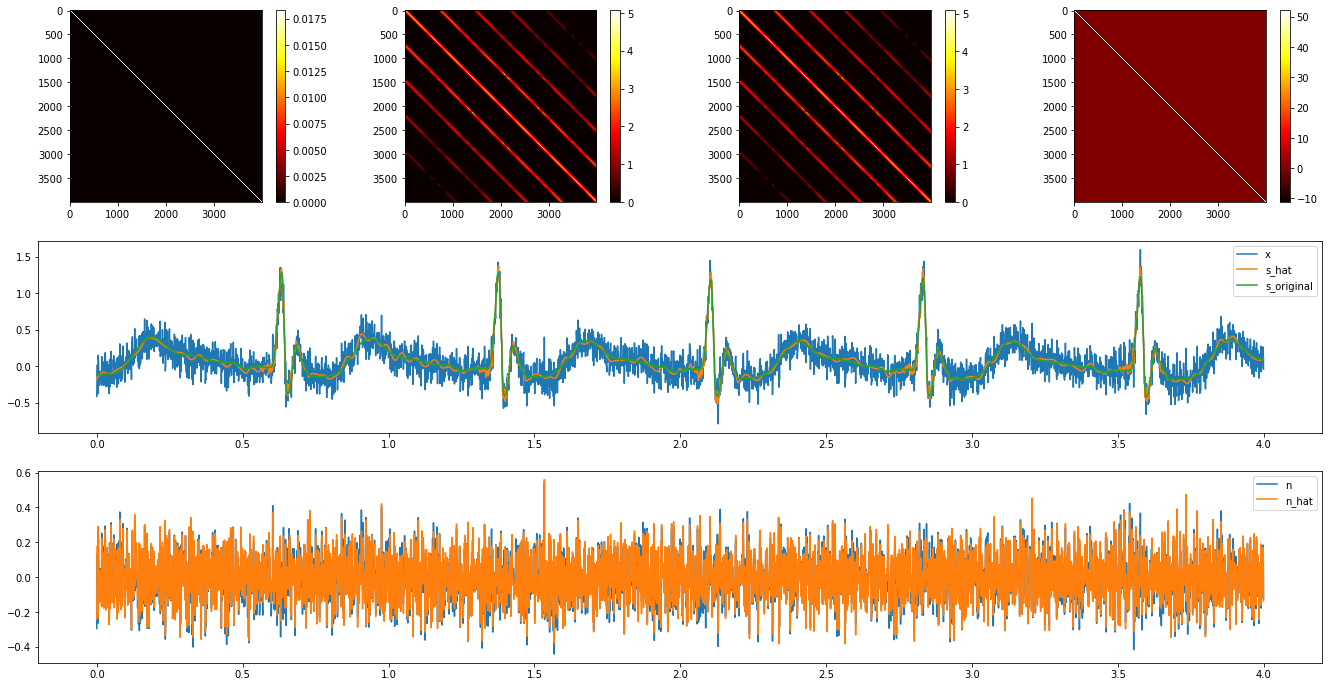

In [21]:
func_plot_GP_filter(23, 12, ker_n, ker_s, time_dec, x_dec, s_hat, s_dec)